# Exploring Class of Device
This notebook explores the class of device property of Bluetooth devices to try to isolate purely automobile observations relative to other modes (bike, ped, transit).

## Summary
Observations from Blip sensors on Richmond and Adelaide, arterials with separated bike facilities, have a substantially greater portion sourced from WiFi devices than on the City's expressways, where different types of Bluetooth device make up a majority of observations. 

This different type of observed device could suggest a bias in observations on arterials. Looking at distributions of raw observations would suggest this: there is a substantially greater proportion of WiFi observations at lower speeds than other common classes of Bluetooth device. However one forgets that slowdowns are typically caused by increased traffic, and therefore the more common type of device will be more present at slower speeds. 

Once observations have been aggregated to 5 minute time bins, these differences in distributions appear to vanish. Scatterplots and linear regression on individual 5min bin observations shows a nearly 1:1 relationship with R^2 above 0.92. 
Averaging these binned observations by hour of day over a month shows similar agreement between device types. 

Comparing Average Absolute Speed Error and Bias by 10km/hr speed bins shows an average error around 5km/hr between 5-min bin observations derived exclusively from WiFi devices, and those derived from Hands-Free Devices (suggested by the supplier as "True" automobile observations) and a bias between positive and negative 3.5km/hr below the speed limit of 50km/hr. Above the speed limit, speeds tend to be substantially more scattered.

**There is no evidence that speeds obtained from WiFi or Smartphone devices are primarily slower cyclists.** For disaggregate 5-min bins, using all available device types is recommended, since this may reduce noise. For averages (for example, for before-after comparison) using exclusively binned observations from Bluetooth devices, or 'Hands-Free Devices', might be preferrable. 

### Outliers
Even after using the I95 method for aggregating observations into 5-min bins, outlier speeds prevailed. Observations of travel time of 0 occured on the `BA2_BA1` & `BR1_BR2` segments, and were primarily caused by WiFi devices. 

Very high speeds were also observed on these segments. `BA2_BA1` & `BR1_BR2` are segments of Adelaide and Richmond Streets between Sherbourne and Parliament, a stretch just over 400m with only one signalized intersection between them: at Berkeley St. It is no surprise that on this stretch, during free flow conditions, speeds can substantially exceed the speed limit. While these are outliers, they are plausible measurements, and should not be discounted. At which speed to suspect a measurement error remains an open question. 

Filtering out travel times of 0 is now added to the `bluetooth.aggr_5min_i95` aggregation. 

In [1]:
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [2]:
CONFIG = configparser.ConfigParser()
CONFIG.read('../../db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

## Exploratory analysis

In [71]:
sql = '''WITH total_cnt AS (SELECT sum(good_count) AS sum_total FROM rdumas.bt_cod_counts)

SELECT cod, device_type, to_char(sum(good_count), '999,999,999') AS "Number of observations",
to_char(100.0*sum(good_count)/sum_total, '99.9')||'%' AS "Proportion of Observations"
FROM rdumas.bt_cod_counts
INNER JOIN bluetooth.class_of_device USING (cod)
CROSS JOIN total_cnt
GROUP BY cod, device_type, sum_total
ORDER BY sum(good_count) DESC
LIMIT 10'''
print_table(sql, con)

cod,device_type,Number of observations,Proportion of Observations
0,WiFi,"86,362,014",42.6%
7995916,Smart phone,"38,399,399",19.0%
2098184,Hands-free Device,"26,912,142",13.3%
3408904,Hands-free Device,"12,235,225",6.0%
3146760,Hands-free Device,"6,436,542",3.2%
5898756,Cellular,"6,269,605",3.1%
5898764,Smart phone,"5,683,055",2.8%
5767684,Cellular,"3,146,918",1.6%
2360324,Wearable Headset Device,"2,802,408",1.4%
2360328,Hands-free Device,"1,534,825",.8%


`cod == 0` are WiFi devices. We're not entirely sure what they are, but I suspect strongly that they are smart phones with WiFi. [Because Bluetooth and WiFi addresses are different](https://stackoverflow.com/a/32732558/4047679) there's no way of knowing these are the same device (though an examination of timestamps and speeds could probably reveal this). So there may very likely be double-counting of smartphones that have Bluetooth and WiFi enabled.

Comparing the distribution of device types from the DVP and Adelaide

In [73]:
sql = pg.SQL('''
WITH total_cnt AS (
    SELECT start_road, sum(good_count) AS sum_total FROM rdumas.bt_cod_counts 
    INNER JOIN bluetooth.ref_segments USING (analysis_id)
    WHERE ARRAY[start_road::TEXT] <@ {road_names}
    GROUP BY start_road
) 
SELECT start_road AS "Route", device_type, 100.0*SUM(good_count)/sum_total AS "Proportion of Observations"
FROM rdumas.bt_cod_counts
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN total_cnt USING (start_road)
GROUP BY  "Route", device_type, sum_total
ORDER BY SUM(good_count)/sum_total DESC
LIMIT 10''')

dvp_adelaide = pandasql.read_sql(sql.format(road_names = pg.Literal(['DVP','Adelaide'])), con)


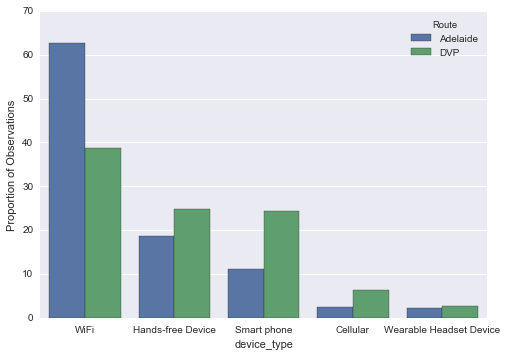

In [74]:
ax = sns.barplot(x='device_type', y="Proportion of Observations", hue='Route', data=dvp_adelaide)
ax.set_ylabel('Proportion of Observations')

The chart above shows a much greater proportion of WIFI devices on Adelaide --a major arterial with a protected bike-lane-- than on the DVP --a major expressway--. We can infer then that people travelling in non-car modes are more likely to have  WIFI devices enabled than a smart phone or cell phone with Bluetooth enabled. 

In [3]:
resultid = pg.Literal('BA3_BA2')
analysis_hour = pg.Literal(datetime.datetime(2016,11,2,7))
sql = pg.SQL('''SELECT measured_timestamp, 3.6*length_m/measured_time as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE segment_name = {resultid} AND outlier_level = 0
AND measured_timestamp BETWEEN {analysis_hour}::TIMESTAMP AND {analysis_hour}::TIMESTAMP + INTERVAL '3 hour'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
''').format(resultid = resultid, analysis_hour = analysis_hour)

adelaide_devices = pandasql.read_sql(sql, con)

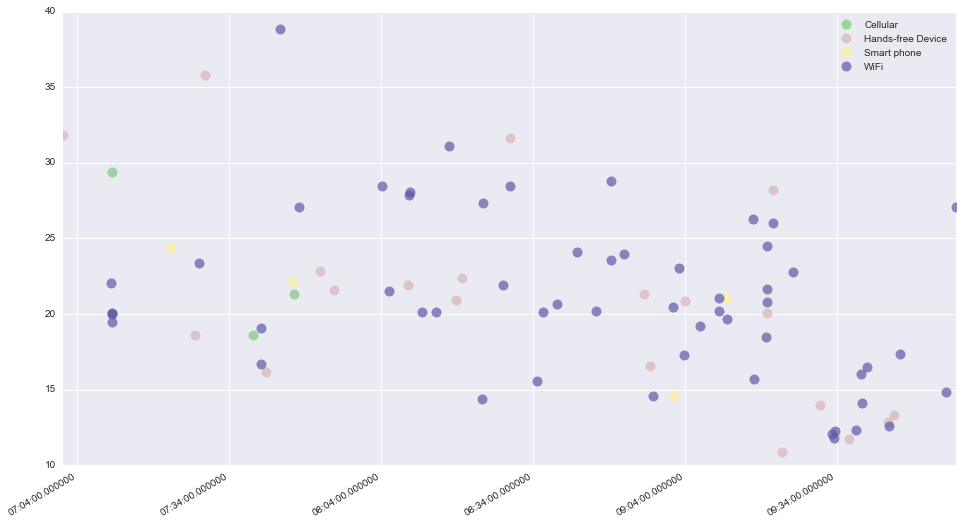

In [4]:
groups = adelaide_devices.groupby('device_type')

fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 5
cm = plt.get_cmap('Accent')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

for i, (device_type, data) in enumerate(groups):
    ax.plot(data.measured_timestamp, data.speed, marker='o', markersize=10,
            alpha=0.7, linestyle='', label=device_type, color=colors[i])
ax.legend()
plt.gcf().autofmt_xdate()

Looking at a few weekend days

In [8]:
resultid = pg.Literal('BA3_BA2')
analysis_hour = pg.Literal(datetime.datetime(2016,10,2,7))
sql = pg.SQL('''SELECT measured_timestamp, 3.6*length_m/measured_time as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE segment_name = {resultid} AND outlier_level = 0
AND measured_timestamp BETWEEN {analysis_hour}::TIMESTAMP AND {analysis_hour}::TIMESTAMP + INTERVAL '8 hour'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
''').format(resultid = resultid, analysis_hour = analysis_hour)

adelaide_devices = pandasql.read_sql(sql, con)

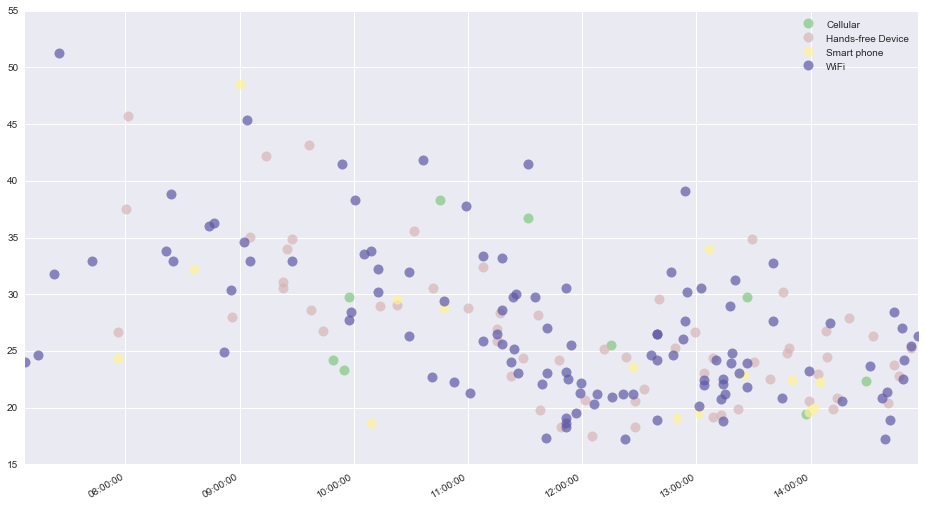

In [9]:
groups = adelaide_devices.groupby('device_type')

fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 5
cm = plt.get_cmap('Accent')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

for i, (device_type, data) in enumerate(groups):
    ax.plot(data.measured_timestamp, data.speed, marker='o', markersize=10,
            alpha=0.7, linestyle='', label=device_type, color=colors[i])
ax.legend()
plt.gcf().autofmt_xdate()

The scatter plots of individual dates don't show any detectable patterns between the 4 category of device. This would hint that it would be hard to determine whether real-time speeds are affected by cyclists or not. This next series of plots will attempt to detect trends over 1 month of data by using a swarm plot aggregated by 15-min bin.

In [11]:
resultid = pg.Literal('BA3_BA2')
analysis_hour = pg.Literal(datetime.time(8))
sql = pg.SQL('''SELECT (EXTRACT(hour from measured_timestamp::TIME)::TEXT ||':'|| (trunc(EXTRACT(minute from measured_timestamp::TIME)/15)*15)::TEXT)::TIME as timebin,
3.6*length_m/measured_time as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE segment_name = {resultid} AND outlier_level = 0
AND measured_timestamp::TIME BETWEEN {analysis_hour}::TIME AND {analysis_hour}::TIME + INTERVAL '1 hour'
AND EXTRACT('isodow' FROM measured_timestamp) BETWEEN 2 and 4
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
ORDER BY device_type, timebin
''').format(resultid = resultid, analysis_hour = analysis_hour)

adelaide_october = pandasql.read_sql(sql, con)

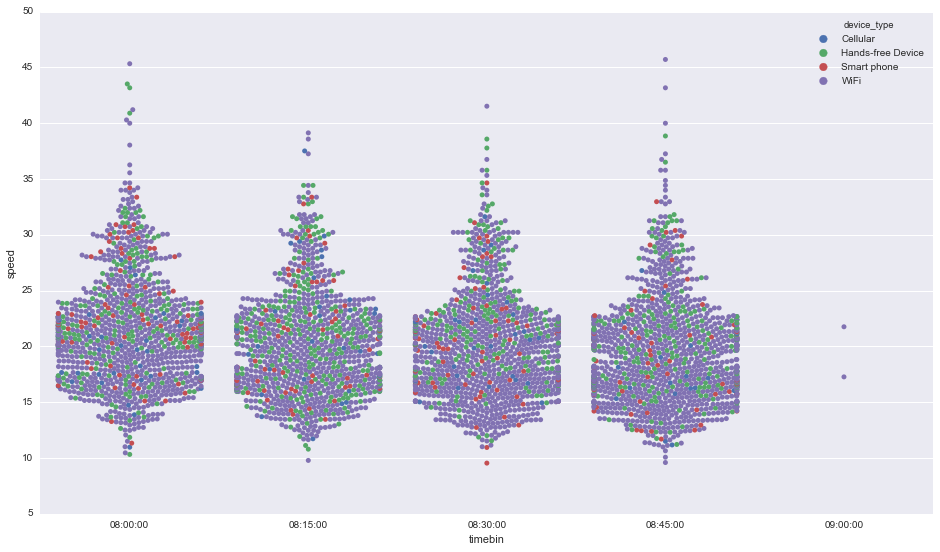

In [12]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
swarm = sns.swarmplot(x='timebin', y='speed', hue='device_type', data=adelaide_october, ax=ax)

Since there's a bit too much data, let's have a better look at the distributions. Comparing the two main device types.

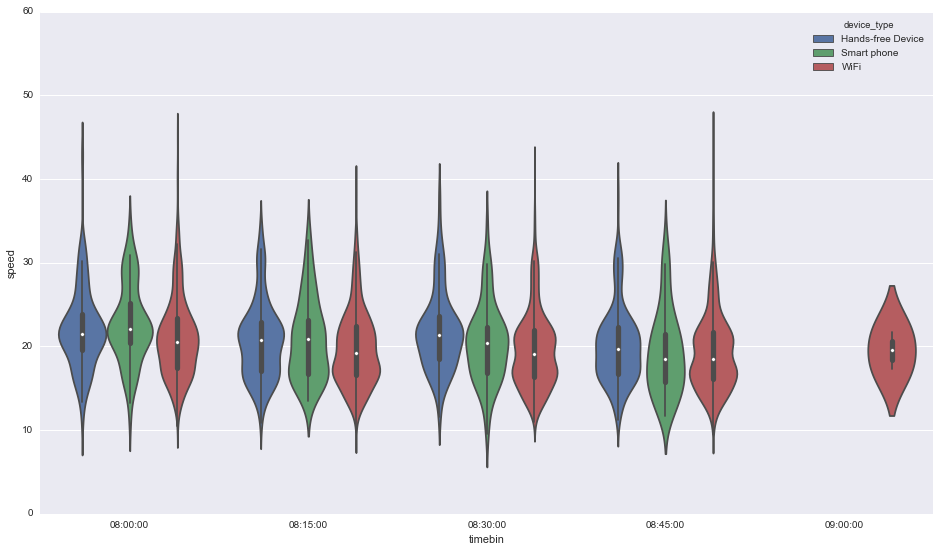

In [13]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
violin = sns.violinplot(x='timebin', y='speed', hue='device_type',
                        data=adelaide_october[adelaide_october['device_type'].isin(['WiFi','Hands-free Device', 'Smart phone'])],
                        ax=ax)

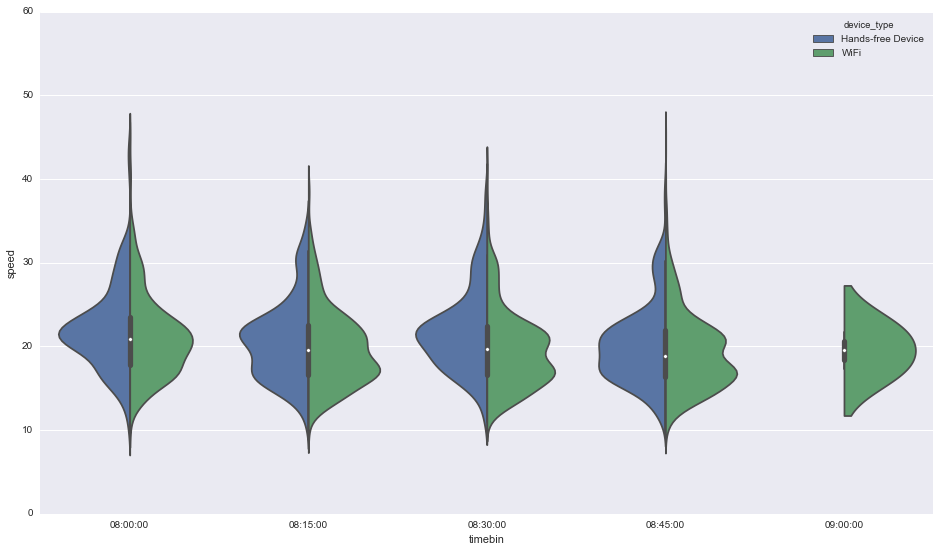

In [14]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
violin = sns.violinplot(x='timebin', y='speed', hue='device_type',
                        data=adelaide_october[adelaide_october['device_type'].isin(['WiFi','Hands-free Device'])],
                        split=True, ax=ax)

In the plot above the WiFi class seems a little more bottom heavy than hands-free, implying it could have a higher proportion of slower vehicles, possibly cyclists. Now looking at the overall Midweek AM Peak for the four main device classes, the difference between the WiFi class and the others striking.

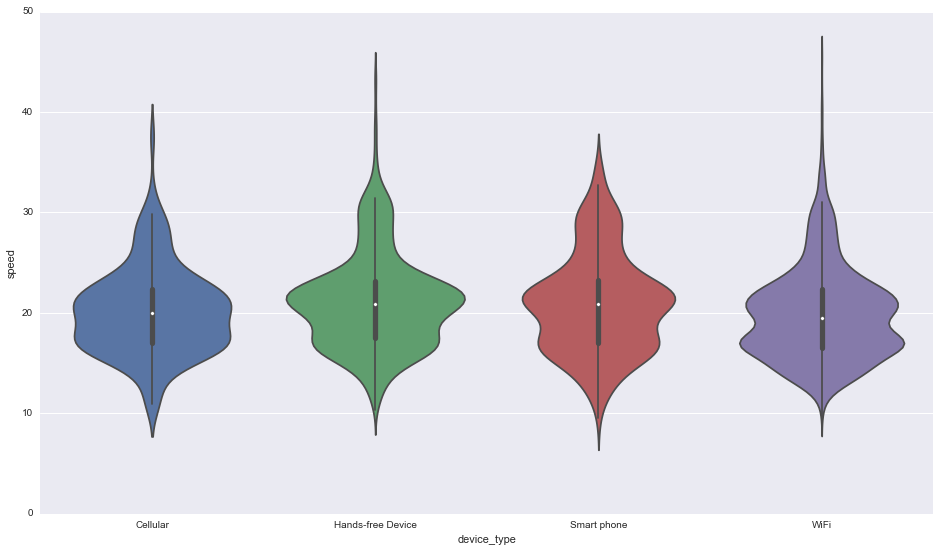

In [15]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
violin = sns.violinplot(x='device_type', y='speed', data=adelaide_october, ax=ax)

Looking at a day of week comparison for the AM

In [8]:
startroad = pg.Literal('Adelaide')
analysis_hour = pg.Literal(datetime.time(8))
sql = pg.SQL('''SELECT CASE EXTRACT('isodow' FROM measured_timestamp)
WHEN 1 THEN 'Monday'
WHEN 5 THEN 'Friday'
WHEN 6 THEN 'Saturday'
WHEN 7 THEN 'Sunday' 
ELSE 'MidWeek' END  AS "Day of Week",
CASE WHEN measured_time < 20 THEN NULL ELSE 3.6*length_m/measured_time END as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road = {start_road} AND outlier_level = 0 
AND measured_timestamp::TIME BETWEEN {analysis_hour}::TIME AND {analysis_hour}::TIME + INTERVAL '1 hour'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
ORDER BY device_type
''').format(start_road = startroad, analysis_hour = analysis_hour)

adelaide_october_dow = pandasql.read_sql(sql, con)

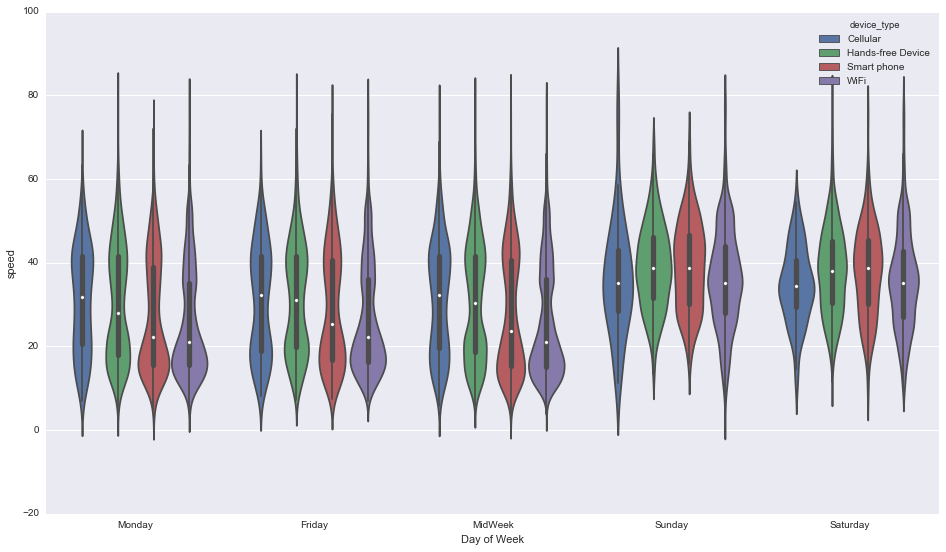

In [9]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
swarm = sns.violinplot(x="Day of Week", y='speed', hue='device_type', data=adelaide_october_dow, ax=ax)

Looking instead at Richmond in the PM 

In [16]:
startroad = pg.Literal('Richmond')
analysis_hour = pg.Literal(datetime.time(16))
sql = pg.SQL('''SELECT CASE EXTRACT('isodow' FROM measured_timestamp)
WHEN 1 THEN 'Monday'
WHEN 5 THEN 'Friday'
WHEN 6 THEN 'Saturday'
WHEN 7 THEN 'Sunday' 
ELSE 'MidWeek' END  AS "Day of Week",
CASE WHEN measured_time < 20 THEN NULL ELSE 3.6*length_m/measured_time END as speed, device_type
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road = {start_road} AND outlier_level = 0 
AND measured_timestamp::TIME BETWEEN {analysis_hour}::TIME AND {analysis_hour}::TIME + INTERVAL '1 hour'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
ORDER BY device_type
''').format(start_road = startroad, analysis_hour = analysis_hour)

richmond_october_dow = pandasql.read_sql(sql, con)

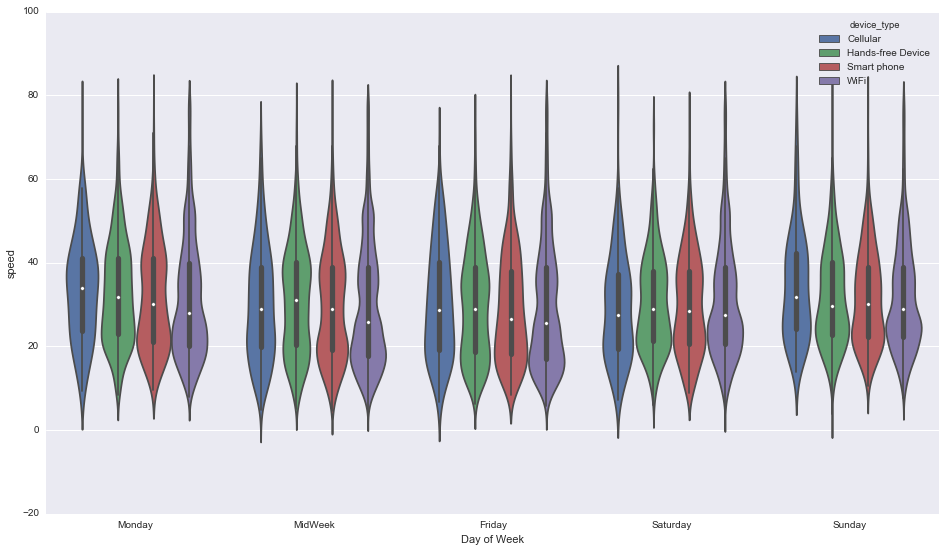

In [17]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
swarm = sns.violinplot(x="Day of Week", y='speed', hue='device_type', data=richmond_october_dow, ax=ax)

### Caveat
It's important to bear in mind here that over 60% of observations are from WiFi devices and in slowdown conditions there are likely more vehicles being observed, so it could make sense that the distribution of WiFi tends to lower speeds than other device types. This next secton will look instead at observations aggregated to 5-min bins.

### 5-min bin observations
Looking at how using only Bluetooth decreases the number of 5-min observations and affects averages from these observations

In [33]:
oct_bt_5min = '''CREATE MATERIALIZED VIEW rdumas.bluetooth_oct AS 

SELECT date_trunc('hour', measured_timestamp) + trunc(EXTRACT(minute from measured_timestamp)/5)* interval '5 minute' as datetime_bin,
analysis_id,
percentile_cont(0.5) WITHIN GROUP (ORDER BY measured_time) as tt, COUNT(1) AS obs
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide') AND outlier_level = 0
AND measured_timestamp >= '2016-10-01'::DATE AND measured_timestamp < '2016-11-01'::DATE + INTERVAL '1 month'
AND device_type != 'WiFi'
GROUP BY analysis_id, datetime_bin '''
with con:
    with con.cursor() as cur:
        cur.execute(oct_bt_5min)


In [65]:
resultid = pg.Literal('BA3_BA2')
analysis_date = pg.Literal(datetime.datetime(2016,10,5))
bt_wifi_day_compare = pg.SQL('''SELECT datetime_bin, 3.6*length_m/bt.tt as "Bluetooth Only",
3.6*length_m/bt_all.tt as "Bluetooth + WiFi"
FROM rdumas.bluetooth_oct bt
RIGHT OUTER JOIN bluetooth.aggr_5min bt_all USING (analysis_id, datetime_bin)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE segment_name = {resultid} 
AND datetime_bin BETWEEN {analysis_date}::TIMESTAMP + INTERVAL '6 hours' 
    AND {analysis_date}::TIMESTAMP + INTERVAL '18 hour'
''').format(resultid = resultid, analysis_date = analysis_date)

bt_wifi_day = pandasql.read_sql(bt_wifi_day_compare, con)

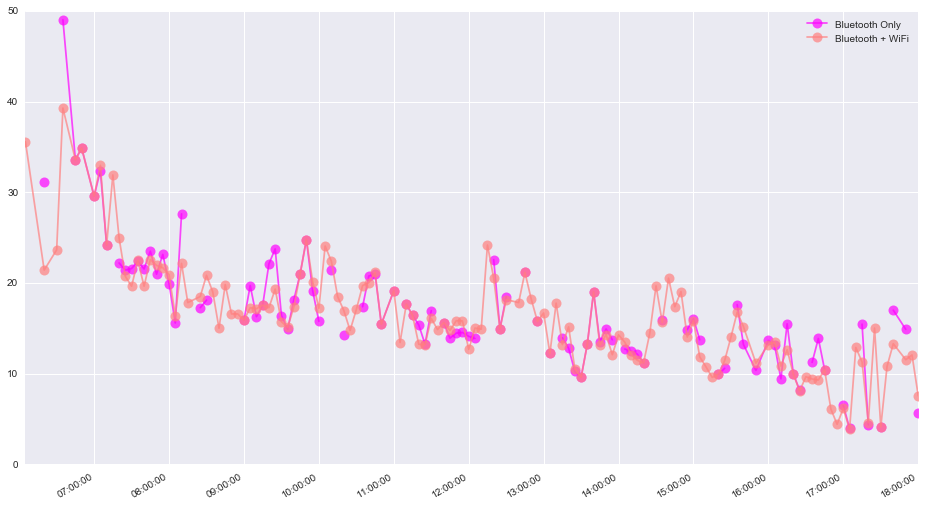

In [66]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 2
cm = plt.get_cmap('spring')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ax.plot(bt_wifi_day.datetime_bin, bt_wifi_day["Bluetooth Only"], marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Bluetooth Only", color=colors[0])

ax.plot(bt_wifi_day.datetime_bin, bt_wifi_day["Bluetooth + WiFi"], marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Bluetooth + WiFi", color=colors[1])

ax.legend()
plt.gcf().autofmt_xdate()

In [78]:
pk_hour = 8
pk_avg = pg.SQL('''SELECT resultid,
    3.6*length_m/AVG(bt.tt) AS "BT AVG Speed", 3.6*length_m/stddev(bt.tt) AS "BT STD Speed", COUNT(bt.tt) AS "Num Time Bins", 
    3.6*length_m/AVG(bt_all.tt) AS "BT-WiFi AVG Speed", 3.6*length_m/stddev(bt_all.tt) AS "BT-WiFi STD Speed", COUNT(bt_all.tt) AS "Num Time Bins"
FROM bluetooth.aggr_5min bt_all 
INNER JOIN bluetooth.ref_segments USING (analysis_id)
LEFT OUTER JOIN rdumas.bluetooth_oct bt USING (analysis_id, datetime_bin)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE EXTRACT('hour' FROM datetime_bin) = {pk_hour} AND EXTRACT('isodow' FROM datetime_bin) < 6
AND start_road IN ('Richmond', 'Adelaide') AND datetime_bin >= '2016-10-01'::DATE AND datetime_bin < '2016-10-01'::DATE + INTERVAL '1 month'
GROUP BY resultid, length_m 
                                    
'''.format(pk_hour=pk_hour))
print_table(pk_avg, con)

resultid,BT AVG Speed,BT STD Speed,Num Time Bins,BT-WiFi AVG Speed,BT-WiFi STD Speed,Num Time Bins
BA2_BA1,37.100345,142.999369,241,37.309060,199.981395,251
BA3_BA2,19.253620,95.904671,149,18.648606,103.704986,235
BA4_BA3,13.846919,51.393276,230,14.090241,57.337982,246
BR1_BR2,31.019436,113.869772,247,30.895958,94.860727,251
BR2_BR3,10.154879,30.421035,61,10.150797,34.156504,141
BR3_BR4,24.589336,84.557245,139,23.926022,88.302008,225


In [80]:
oct_handsfree_5min = '''CREATE MATERIALIZED VIEW rdumas.handfree_oct_nov AS 

SELECT date_trunc('hour', measured_timestamp) + trunc(EXTRACT(minute from measured_timestamp)/5)* interval '5 minute' as datetime_bin,
analysis_id,
percentile_cont(0.5) WITHIN GROUP (ORDER BY measured_time) as tt, COUNT(1) AS obs
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide') AND outlier_level = 0
AND measured_timestamp >= '2016-10-01'::DATE AND measured_timestamp < '2016-11-01'::DATE + INTERVAL '1 month'
AND device_type = 'Hands-free Device'
GROUP BY analysis_id, datetime_bin '''
with con:
    with con.cursor() as cur:
        cur.execute(oct_handsfree_5min)


In [82]:
pk_hour = 17
pk_avg = pg.SQL('''SELECT resultid,
    3.6*length_m/AVG(bt.tt) AS "HF AVG Speed", 3.6*length_m/stddev(bt.tt) AS "HF STD Speed", COUNT(bt.tt) AS "Num Time Bins", 
    3.6*length_m/AVG(bt_all.tt) AS "BT-WiFi AVG Speed", 3.6*length_m/stddev(bt_all.tt) AS "BT-WiFi STD Speed", COUNT(bt_all.tt) AS "Num Time Bins"
FROM bluetooth.aggr_5min bt_all 
INNER JOIN bluetooth.ref_segments USING (analysis_id)
LEFT OUTER JOIN rdumas.handfree_oct_nov bt USING (analysis_id, datetime_bin)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE EXTRACT('hour' FROM datetime_bin) = {pk_hour} AND EXTRACT('isodow' FROM datetime_bin) < 6
AND start_road IN ('Richmond', 'Adelaide') AND datetime_bin >= '2016-10-01'::DATE AND datetime_bin < '2016-10-01'::DATE + INTERVAL '1 month'
GROUP BY resultid, length_m 
                                    
'''.format(pk_hour=pk_hour))
print_table(pk_avg, con)

resultid,HF AVG Speed,HF STD Speed,Num Time Bins,BT-WiFi AVG Speed,BT-WiFi STD Speed,Num Time Bins
BA2_BA1,34.673477,138.666410,240,33.152112,154.118294,252
BA3_BA2,8.180631,22.707364,126,8.546662,22.667681,244
BA4_BA3,12.740021,23.950053,102,12.227734,23.104918,245
BR1_BR2,32.437887,98.481647,217,35.303726,147.619163,252
BR2_BR3,8.916191,38.302881,35,9.004323,34.138247,125
BR3_BR4,13.220122,38.213447,134,14.262587,47.781496,245


Differences in averages seem minimal across the 6 segments looking at different peak hours and Bluetooth overall versus just "Hand's Free" devices. Redoing the violin plots from above with binned observations 

In [89]:
pk_hour = 8

agg_violin_sql = pg.SQL('''SELECT resultid, CASE EXTRACT('isodow' FROM datetime_bin)
WHEN 1 THEN 'Monday'
WHEN 5 THEN 'Friday'
WHEN 6 THEN 'Saturday'
WHEN 7 THEN 'Sunday' 
ELSE 'MidWeek' END  AS "Day of Week",
3.6*length_m/NULLIF(hf.tt,0) AS "Hands Free",
3.6*length_m/NULLIF(bt.tt,0) AS "Bluetooth (All)",
3.6*length_m/NULLIF(bt_all.tt,0) AS "Bluetooth + WiFi"
FROM bluetooth.aggr_5min bt_all 
INNER JOIN bluetooth.ref_segments USING (analysis_id)
LEFT OUTER JOIN rdumas.handfree_oct_nov hf USING (analysis_id, datetime_bin)
LEFT OUTER JOIN rdumas.bluetooth_oct bt USING (analysis_id, datetime_bin)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE EXTRACT('hour' FROM datetime_bin) = {pk_hour} 
AND start_road IN ('Richmond', 'Adelaide') AND datetime_bin >= '2016-10-01'::DATE AND datetime_bin < '2016-10-01'::DATE + INTERVAL '1 month'
'''.format(pk_hour=pk_hour))

agg_violin_data = pandasql.read_sql(agg_violin_sql, con)

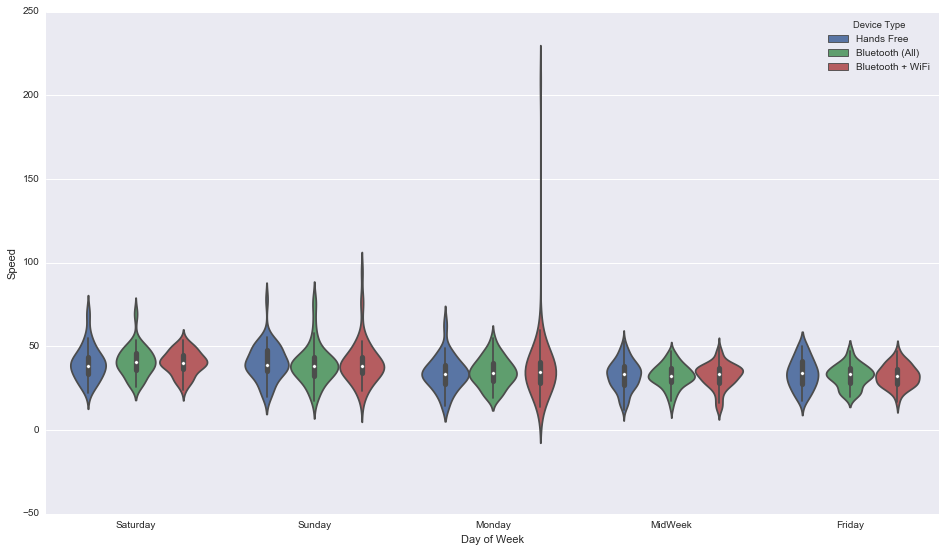

In [92]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

data = pd.melt( agg_violin_data[agg_violin_data.resultid == 'BR1_BR2'], id_vars=['resultid','Day of Week'], 
              value_vars=["Hands Free","Bluetooth (All)","Bluetooth + WiFi"], var_name='Device Type', value_name='Speed')

swarm = sns.violinplot(x="Day of Week", y='Speed', hue='Device Type', data=data, ax=ax)

## Hexbin Plots
Comparing 5-min aggregated observations by device type. 

In [8]:
device_type_5min = '''CREATE MATERIALIZED VIEW rdumas.bluetooth_device_type_aggr_oct_nov AS 

SELECT date_trunc('hour', measured_timestamp) + trunc(EXTRACT(minute from measured_timestamp)/5)* interval '5 minute' as datetime_bin,
analysis_id, device_type,
percentile_cont(0.5) WITHIN GROUP (ORDER BY measured_time) as tt, COUNT(1) AS obs
FROM bluetooth.observations
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide') AND outlier_level = 0
AND measured_timestamp >= '2016-10-01'::DATE AND measured_timestamp < '2016-11-01'::DATE + INTERVAL '1 month'
AND device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone')
GROUP BY analysis_id, datetime_bin, device_type '''
with con:
    with con.cursor() as cur:
        cur.execute(device_type_5min)


In [3]:
hex_plot_sql = '''SELECT resultid, datetime_bin,
3.6*length_m/NULLIF(tt,0) AS "Speed",
device_type
FROM rdumas.bluetooth_device_type_aggr_oct_nov  
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide') AND 3.6*length_m/NULLIF(tt,0) < 60
ORDER BY resultid, datetime_bin, device_type
'''   
hex_plot_data = pandasql.read_sql(hex_plot_sql, con)

In [4]:
hex_plot_data = hex_plot_data.pivot_table(columns='device_type', values="Speed", index=['resultid','datetime_bin'])

In [33]:
import statsmodels.api as sm


#jointplot's stat_func parameter takes a statistical function that processes two arguments: columns x & y, and returns 
#two values: the statistic, and (typically) a p-value.
def lin_func(x, y):
    results = sm.OLS(y, x).fit()
    return results.params[0], results.rsquared
#From https://github.com/mwaskom/seaborn/blob/50da47924a6c65d8a75d0d70f5b8319d043a1fa8/seaborn/axisgrid.py#L1786
#Have to modify template so that "p" is actually labelled r^2 for linear model
annotation_template = "{stat} = {val:.2g}; r^2 = {p:.2g}"

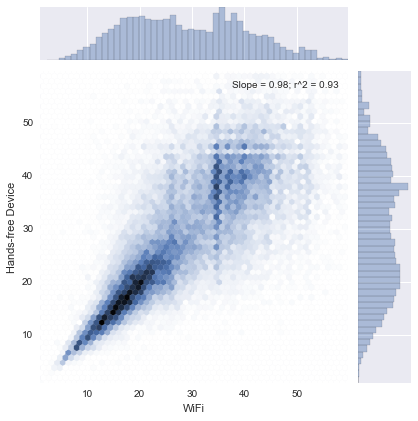

In [34]:
data = (hex_plot_data[["Hands-free Device","WiFi"]]).dropna()
ax = sns.jointplot(data["WiFi"], data["Hands-free Device"], kind='hex',
                  stat_func=lin_func, annot_kws=dict(template=annotation_template, stat='Slope'))

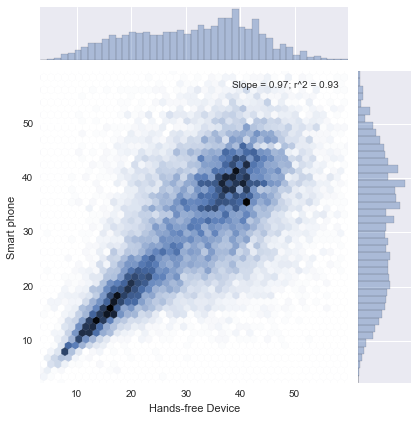

In [37]:
data = (hex_plot_data[["Smart phone","Hands-free Device"]]).dropna()
ax = sns.jointplot("Hands-free Device", "Smart phone",  data=data, kind='hex',
                  stat_func=lin_func, annot_kws=dict(template=annotation_template, stat='Slope'))

The plots above highlight some peculiarities in the observations: the aggregated 5-min observations based on WiFi seem to have unusual concentrations at specific speeds between 30 and 40 km/hr. This seems to be particularly driven by the `BA2_BA1` segment as evidenced by the table below.

In [25]:
sql = '''SELECT resultid, trunc(3.6*length_m/NULLIF(tt,0)) speed, COUNT(1) AS "Num 5-min bins"

  FROM bluetooth_device_type_aggr_oct_nov
  INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
  WHERE device_type = 'WiFi' AND trunc(3.6*length_m/NULLIF(tt,0)) between 30 and 40 AND resultid = 'BA2_BA1'
  GROUP BY speed, resultid
  ORDER BY resultid, speed '''
print_table(sql, con)

resultid,speed,Num 5-min bins
BA2_BA1,30.0,269
BA2_BA1,31.0,453
BA2_BA1,32.0,346
BA2_BA1,33.0,596
BA2_BA1,34.0,779
BA2_BA1,35.0,1152
BA2_BA1,36.0,1176
BA2_BA1,37.0,769
BA2_BA1,38.0,775
BA2_BA1,39.0,1065


## Absolute Error and Bias
Using I95 metrics to compare error between device types

In [3]:
sql = '''SELECT 10*trunc(3.6*length_m/wifi.tt /10) AS "Speed Bin",
	avg(abs(3.6*length_m/wifi.tt - 3.6*length_m/hfd.tt)) AS "AASE",
	avg((3.6*length_m/wifi.tt - 3.6*length_m/hfd.tt)) AS "Bias"
  FROM bluetooth_device_type_aggr_oct_nov wifi
  INNER JOIN bluetooth_device_type_aggr_oct_nov hfd USING (datetime_bin, analysis_id)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide')
  AND wifi.device_type = 'WiFi' AND hfd.device_type = 'Hands-free Device'
AND wifi.tt > 0  AND hfd.tt > 0
GROUP BY "Speed Bin"
ORDER BY "Speed Bin"'''
print_table(sql, con)

Speed Bin,AASE,Bias
0.0,2.191371,-1.516504
10.0,4.135538,-2.555428
20.0,6.314624,-3.068913
30.0,6.784569,-1.252539
40.0,7.821559,3.872430
50.0,13.831681,11.170584
60.0,23.784917,22.805787
70.0,34.363876,34.363876
80.0,42.741050,42.741050
90.0,51.106874,50.741079


In [5]:
sql = '''SELECT 10*trunc(3.6*length_m/smart.tt /10) AS "Speed Bin",
	avg(abs(3.6*length_m/smart.tt - 3.6*length_m/hfd.tt)) AS "AASE",
	avg((3.6*length_m/smart.tt - 3.6*length_m/hfd.tt)) AS "Bias"
  FROM bluetooth_device_type_aggr_oct_nov smart
  INNER JOIN bluetooth_device_type_aggr_oct_nov hfd USING (datetime_bin, analysis_id)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide')
  AND smart.device_type = 'Smart phone' AND hfd.device_type = 'Hands-free Device'
AND smart.tt > 10  AND hfd.tt > 10
GROUP BY "Speed Bin"
ORDER BY "Speed Bin"'''
print_table(sql, con)

Speed Bin,AASE,Bias
0.0,2.360922,-1.735983
10.0,4.764555,-3.076255
20.0,7.115907,-4.195148
30.0,6.517723,-0.631720
40.0,7.657648,4.866372
50.0,13.954458,13.206395
60.0,24.011960,24.011960
70.0,35.268525,32.837005
80.0,44.821386,44.821386
90.0,55.924599,55.924599


### After Using the I95 filtering method
The I95 Corridor Coalition developed a method for filtering bluetooth observations beyond merely looking at the outlier level. The script for all observations is [here](../bt-load-aggr_5min_i95.sql), and a remix of `rdumas.bluetooth_device_type_aggr_oct_nov` was created using it. This first table compares the Average Absolute Error and Bias between aggregated observations using only WiFi devices, and aggregated observations using only Hands-Free Devices (most likely cars)

In [16]:
sql = '''SELECT 10*trunc(3.6*length_m/wifi.travel_time /10) AS "Speed Bin",
	avg(abs(3.6*length_m/wifi.travel_time - 3.6*length_m/hfd.travel_time)) AS "AASE",
	avg((3.6*length_m/wifi.travel_time - 3.6*length_m/hfd.travel_time)) AS "Bias",
    COUNT(1) AS "Num Time Bins",
    SUM(wifi.obs) AS "WiFi observations"
  FROM bluetooth_device_type_aggr_oct_nov_i95 wifi
  INNER JOIN bluetooth_device_type_aggr_oct_nov_i95 hfd USING (datetime_bin, analysis_id)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide')
  AND wifi.device_type = 'WiFi' AND hfd.device_type = 'Hands-free Device'
AND wifi.std_time/wifi.travel_time < 1 AND hfd.std_time/hfd.travel_time < 1
AND wifi.travel_time > 0  AND hfd.travel_time > 0
GROUP BY "Speed Bin"
ORDER BY "Speed Bin"'''
print_table(sql, con)

Speed Bin,AASE,Bias,Num Time Bins,WiFi observations
0.0,1.374917,-0.759344,229,892.0
10.0,2.710921,-1.467419,2127,9701.0
20.0,5.344124,-3.214504,4208,24441.0
30.0,5.084506,-1.389120,6536,40466.0
40.0,5.736518,3.255821,3370,17744.0
50.0,13.068313,12.587380,528,2103.0
60.0,25.001133,25.001133,103,430.0
70.0,32.375197,32.375197,43,187.0
80.0,43.125965,43.125965,16,63.0
90.0,49.907483,49.907483,6,16.0


From 20km/hr to 50km/hr average absolute error plateaus at 5km/hr, which is rather high. Until 40 km/hr WiFi-only binned observations tend to be slightly slower than Hands-Free-only observations. At 50km/hr and above error rises rapidly with speed, likely due to outliers. Interestingly, bias and error become almost the same, implying a directionality above 50km/hr: that (almost) all observations above 50km/hr are, on average ~13km/hr faster. 
Comparing Hands-Free Devices with aggregated time bins containing all devices in the table below, we see low bias until 40km/hr, but absolute error rises with rising speeds.

In [7]:
sql = '''SELECT 10*trunc(3.6*length_m/wifi.travel_time /10) AS "Speed Bin",
	avg(abs(3.6*length_m/wifi.travel_time - 3.6*length_m/hfd.travel_time)) AS "AASE",
	avg((3.6*length_m/wifi.travel_time - 3.6*length_m/hfd.travel_time)) AS "Bias",
    COUNT(1) AS "Num Time Bins",
    to_char(100.0*SUM(wifi.obs)/SUM(hfd.obs), '999.9')||'%' AS "Proportion of WiFi observations"
  FROM bluetooth_device_type_aggr_oct_nov_i95 wifi
  INNER JOIN bluetooth.aggr_5min_i95 hfd USING (datetime_bin, analysis_id)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide')
  AND wifi.device_type = 'WiFi' 
AND wifi.std_time/wifi.travel_time < 1 AND hfd.std_time/hfd.travel_time < 1
AND hfd.obs > 3
AND wifi.travel_time > 0  AND hfd.travel_time > 0
GROUP BY "Speed Bin"
ORDER BY "Speed Bin"'''
print_table(sql, con)

Speed Bin,AASE,Bias,Num Time Bins,Proportion of WiFi observations
0.0,0.318851,-0.120173,1087,71.1%
10.0,0.700344,-0.285299,9938,70.4%
20.0,1.480013,-0.624070,11773,63.9%
30.0,1.965797,-0.258621,11621,59.1%
40.0,2.484884,1.598932,6719,60.3%
50.0,5.942577,5.660274,1311,59.8%
60.0,11.869755,11.844310,338,61.9%
70.0,17.871765,17.649358,111,62.5%
80.0,24.776597,24.594333,47,59.5%
90.0,29.449294,29.449294,19,61.5%


## Identifying the Where, When, What of Outliers
Since, despite the I95 filtering, very high speeds remained, I wanted to identify on which segments, and from which device classes these high speeds were coming.

In [ ]:
sql = '''SELECT resultid, device_type, COUNT(1) AS "Num Bins"
FROM bluetooth_device_type_aggr_oct_nov
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide')
AND (tt = 0 OR 3.6*length_m/tt > 70)
GROUP BY resultid, device_type
'''

outliers_by_resultid_device_type = pandasql.read_sql(sql, con)

In [11]:
outliers_by_resultid_device_type.pivot_table(columns='resultid', values="Num Bins", index="device_type")

resultid,BA2_BA1,BR1_BR2,BR3_BR4
device_type,,,
Cellular,26.0,25.0,NaN
Hands-free Device,51.0,71.0,1.0
Smart phone,29.0,69.0,1.0
WiFi,190.0,1040.0,NaN


Just looking at 0 values

In [15]:
sql = '''SELECT resultid, device_type, COUNT(1) AS "Num Bins"
FROM bluetooth_device_type_aggr_oct_nov
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide')
AND (tt = 0)
GROUP BY resultid, device_type
'''

outliers_by_resultid_device_type = pandasql.read_sql(sql, con)
outliers_by_resultid_device_type.pivot_table(columns='resultid', values="Num Bins", index="device_type")

resultid,BA2_BA1,BR1_BR2
device_type,,
Smart phone,NaN,7.0
WiFi,35.0,140.0


In [14]:
sql = '''SELECT resultid, EXTRACT('hour' FROM datetime_bin) as hour_of_day, COUNT(1)AS "Num Bins"
FROM bluetooth_device_type_aggr_oct_nov
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN gis.bluetooth_routes ON segment_name = resultid
WHERE start_road IN ('Richmond', 'Adelaide')
AND (tt = 0 OR 3.6*length_m/tt > 70)
GROUP BY resultid, hour_of_day
'''

outliers_by_resultid_hod = pandasql.read_sql(sql, con)
outliers_by_resultid_hod.pivot_table(columns='resultid', values="Num Bins", index="hour_of_day")

resultid,BA2_BA1,BR1_BR2,BR3_BR4
hour_of_day,,,
0.0,12.0,71.0,NaN
1.0,18.0,93.0,NaN
2.0,23.0,83.0,NaN
3.0,18.0,70.0,NaN
4.0,35.0,76.0,NaN
5.0,39.0,96.0,NaN
6.0,31.0,80.0,NaN
7.0,32.0,56.0,NaN
8.0,11.0,26.0,1.0


`BA2_BA1` & `BR1_BR2` are segments of Adelaide and Richmond Streets between Sherbourne and Parliament, a stretch just over 400m with only one signalized intersection between them: at Berkeley St. It is no surprise that on this stretch, during free flow conditions, speeds can substantially exceed the speed limit. While these are outliers, they are plausible measurements, and should not be discounted. At which speed to suspect a measurement error remains an open question. 

## Preliminary Conclusion
On arterials with separated bike lanes, the distribution of speed observations from WiFi devices seems solidly distinct from Bluetooth device speeds. On both Richmond and Adelaide, speeds from WiFi devices tend lower than from Bluetooth. However, this seems likely due to there being more WiFI observations, and therefore more observations during congested conditions. When aggregating observations into 5-minute bins, one should use all device types.

## Deeper Analysis
The above analysis was performed before the addition of 140 new routes Downtown. With the addition of these new routes, the topic of classes of device and potential biases by route types needed to be revisited.

In [3]:
sql = '''WITH cnts AS (SELECT street_name, from_intersection || '-' ||to_intersection as from_to_streets, device_type AS "Device Type", COUNT(1) as "Num observations"
FROM bluetooth.observations_201711
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN king_pilot.bt_segments USING (analysis_id)
WHERE device_class = 1
GROUP BY street_name, from_intersection, to_intersection, device_type)
, tots AS (SELECT street_name, from_to_streets, SUM("Num observations") AS total_cnt
FROM cnts
GROUP BY street_name, from_to_streets)
, most_popular_devices AS( SELECT "Device Type", SUM("Num observations") AS total_cnt
FROM cnts
GROUP BY "Device Type" 
ORDER BY total_cnt DESC LIMIT 8)
SELECT tots.street_name, tots.from_to_streets, dev."Device Type", 100.0*COALESCE(SUM("Num observations") OVER w, 0.0)/total_cnt as bottom, 
COALESCE(100.0*"Num observations"/total_cnt, 0) as "% of Observations", COALESCE("Num observations", 0)as "Num observations"
FROM tots
INNER JOIN cnts USING (street_name, from_to_streets)
RIGHT OUTER JOIN (SELECT "Device Type", street_name, from_to_streets, row_number() OVER (ORDER BY total_cnt DESC) AS device_rank 
                  FROM  most_popular_devices
                  CROSS JOIN (SELECT DISTINCT street_name, from_to_streets FROM cnts) st
                  ) dev ON dev."Device Type" = cnts."Device Type" AND dev.street_name = cnts.street_name
                      AND dev.from_to_streets = cnts.from_to_streets
WINDOW w AS (PARTITION BY tots.street_name, tots.from_to_streets ORDER BY device_rank ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING)
ORDER BY street_name, from_to_streets'''
class_of_device_obs_count = pandasql.read_sql(sql, con)

In [6]:
#class_of_device_obs_count.to_pickle('class_of_device_by_route.pkl')
class_of_device_obs_count = pd.read_pickle('class_of_device_by_route.pkl')

In [7]:
streets = class_of_device_obs_count[['street_name', 'from_to_streets']].drop_duplicates()
major_ticks = np.cumsum(streets.groupby('street_name').count().from_to_streets.values)
major_ticks

array([  5,   6,  16,  18,  22,  26,  40,  41,  45,  54,  55,  61,  79,
        87, 105, 110, 112, 120, 122, 130, 132, 138, 140], dtype=int64)

In [8]:
NUM_COLORS = 8
cm = plt.get_cmap('Paired')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

In [9]:
minor_ticks = range(1,141)
minor_labels = streets.from_to_streets.values

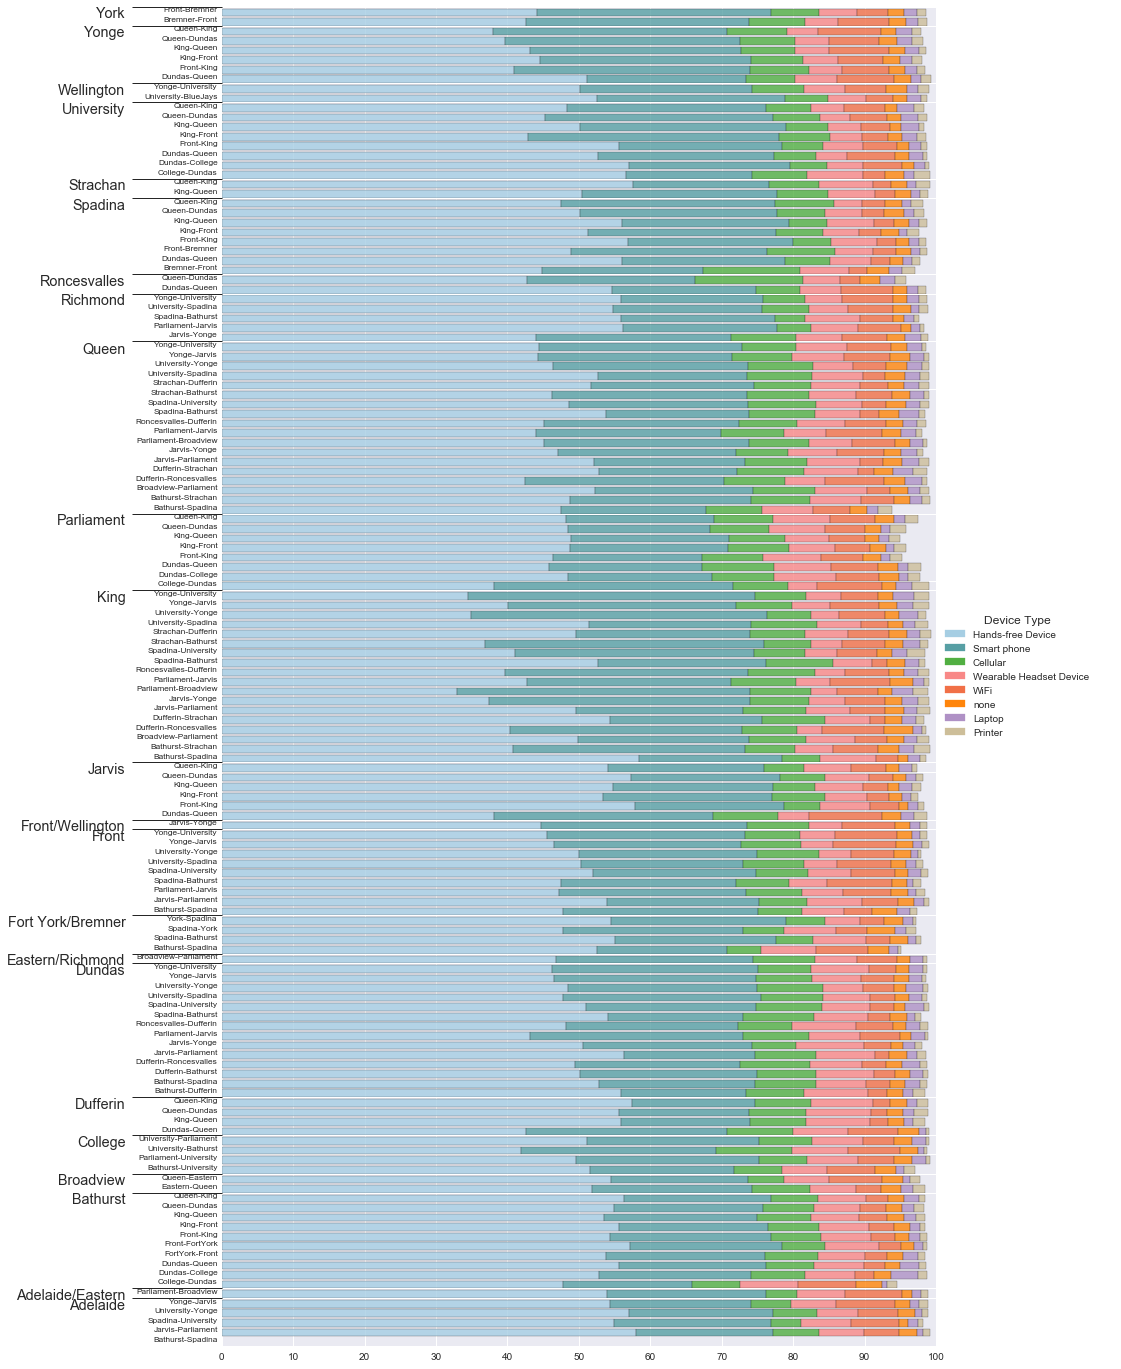

In [12]:
handles = []
fig, ax = plt.subplots(1,1, figsize=(16,24))
for i, device_type in enumerate(class_of_device_obs_count["Device Type"].unique()):
    device_data = class_of_device_obs_count[class_of_device_obs_count["Device Type"] == device_type]
    ax.barh(minor_ticks, device_data["% of Observations"], left=device_data.bottom, color=colors[i], alpha=0.8)
    handles.append(mpl.patches.Patch(color=colors[i], label=device_type))

ax.set_ylim([0,140])
newax = ax.twinx()
newax.set_frame_on(True)
newax.patch.set_visible(False)
newax.yaxis.set_ticks_position('left')
newax.yaxis.set_label_position('left')

# From https://stackoverflow.com/a/4701285/4047679
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(title="Device Type", handles=list(handles), loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True)

newax.set_yticks(major_ticks)
newax.set_yticklabels(class_of_device_obs_count.street_name.unique(), size='large', x=-0.1)
newax.tick_params(axis='y', which='major', direction='out', length='90')

ax.tick_params(axis='y',
               which='major',
               left='off',
               right='off',
               labelleft='off')
ax.set_yticks(minor_ticks, minor=True)
[t.set_verticalalignment('top') for t in ax.yaxis.get_minorticklabels()]
[t.set_verticalalignment('top') for t in newax.yaxis.get_majorticklabels()]
ax.set_yticklabels(minor_labels, minor=True, size='x-small');

ax.set_xticks(range(0,110,10));

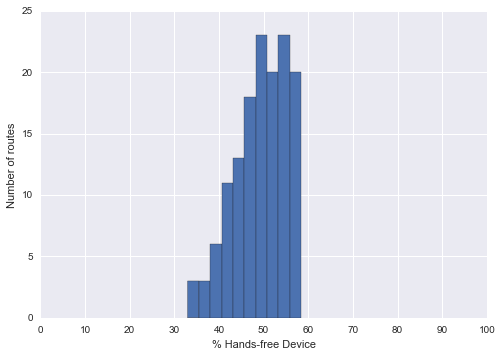

In [33]:
ax = class_of_device_obs_count[class_of_device_obs_count['Device Type']=='Hands-free Device']["% of Observations"].hist()
ax.set_xlim([0,100])
ax.set_xlabel('% Hands-free Device')
ax.set_xticks(range(0,102,2), minor=True)
ax.set_xticks(range(0,102,10), minor=False)
ax.set_ylabel('Number of routes');

**Observations**:
1. There is substantial variation in the proportion of Hands-free Devices: between 38%-58% of Bluetooth observations
2. Only on King Street (during the Pilot) do Smartphone observations outnumber 
3. Contrary to expectation, cycletrack corridors (Adelaide and Richmond) actually have some of the higher proportions of Hands-free Devices. Jarvis has consistently high proportions of Hands-free Device observations. Yonge has a consistently lower proportion Hands-free Device 
4. Different directions of the same segment can have a 10% difference in HfD observations, e.g. College between Bathurst-University, Dufferin between Queen & Dundas.
5. This graph only shows the proportion of the top 8 most common device types, the "Other" category is empty space to the right. On some routes "Other" can be as much as 7% of observations.

In [23]:
sql = '''WITH cnts AS (SELECT street_name, from_intersection || '-' ||to_intersection as from_to_streets,
    device_type AS "Device Type", COUNT(1)/30 as "Num observations"
FROM bluetooth.observations_201711
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN king_pilot.bt_segments USING (analysis_id)
WHERE device_class = 1
GROUP BY street_name, from_intersection, to_intersection, device_type)
, tots AS (SELECT street_name, from_to_streets, SUM("Num observations") AS total_cnt
FROM cnts
GROUP BY street_name, from_to_streets)
, most_popular_devices AS( SELECT "Device Type", SUM("Num observations") AS total_cnt
FROM cnts
GROUP BY "Device Type" 
ORDER BY total_cnt DESC LIMIT 8)
SELECT cnts.street_name, cnts.from_to_streets, dev."Device Type", COALESCE(SUM("Num observations") OVER w, 0)  as bottom, 
COALESCE("Num observations", 0)as "Num observations"
FROM cnts
RIGHT OUTER JOIN (SELECT "Device Type", street_name, from_to_streets, row_number() OVER (ORDER BY total_cnt DESC) AS device_rank 
                  FROM  most_popular_devices
                  CROSS JOIN (SELECT DISTINCT street_name, from_to_streets FROM cnts) st
                  ) dev ON dev."Device Type" = cnts."Device Type" AND dev.street_name = cnts.street_name
                      AND dev.from_to_streets = cnts.from_to_streets
WINDOW w AS (PARTITION BY cnts.street_name, cnts.from_to_streets ORDER BY device_rank ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING)
ORDER BY street_name, from_to_streets'''
class_of_device_obs_count_abs = pandasql.read_sql(sql, con)

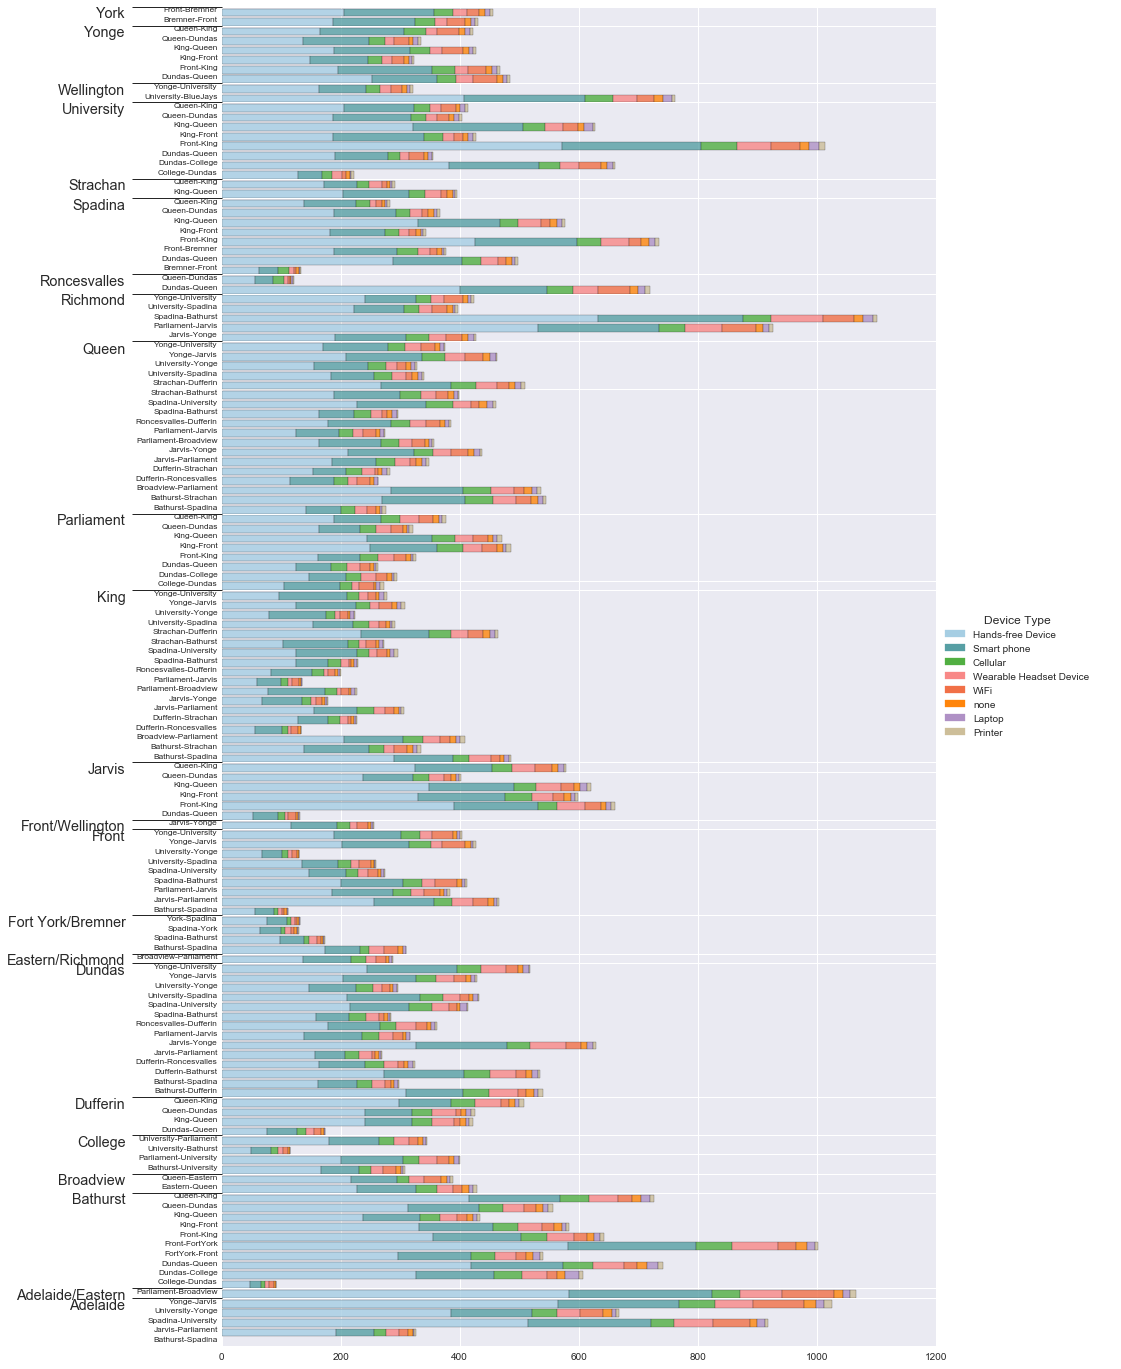

In [24]:
handles = []
fig, ax = plt.subplots(1,1, figsize=(16,24))
for i, device_type in enumerate(class_of_device_obs_count_abs["Device Type"].unique()):
    device_data = class_of_device_obs_count_abs[class_of_device_obs_count_abs["Device Type"] == device_type]
    ax.barh(minor_ticks, device_data["Num observations"], left=device_data.bottom, color=colors[i], alpha=0.8)
    handles.append(mpl.patches.Patch(color=colors[i], label=device_type))

ax.set_ylim([0,140])
newax = ax.twinx()
newax.set_frame_on(True)
newax.patch.set_visible(False)
newax.yaxis.set_ticks_position('left')
newax.yaxis.set_label_position('left')

# From https://stackoverflow.com/a/4701285/4047679
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(title="Device Type", handles=list(handles), loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True)

newax.set_yticks(major_ticks)
newax.set_yticklabels(class_of_device_obs_count_abs.street_name.unique(), size='large', x=-0.1)
newax.tick_params(axis='y', which='major', direction='out', length='90')

ax.tick_params(axis='y',
               which='major',
               left='off',
               right='off',
               labelleft='off')
ax.set_yticks(minor_ticks, minor=True)
[t.set_verticalalignment('top') for t in ax.yaxis.get_minorticklabels()]
[t.set_verticalalignment('top') for t in newax.yaxis.get_majorticklabels()]
ax.set_yticklabels(minor_labels, minor=True, size='x-small');

**Observation**:
1. The variation is pretty remarkable: 100-1100 observations/day 
2. Most of the routes with very low observation counts appear to be due to stark directional differences:
   - Bathurst between College & Dundas varies between 100 & 700 
   - College between University & Bathurst varies between 100 & 250
   - Dufferin between Dundas & Queen varies between 180 & 420
   - Front between Bathurst & Spadina varies between 100 & 400
   - Jarvis between Dundas & Queen varies between 100 & 400
   - Roncesvalles between Queen & Dundas varies between 100 & 1700
3. While these differences (2.5-7x) are far greater than the variation in proportion of device types (10-20%), similar segments are affected. 

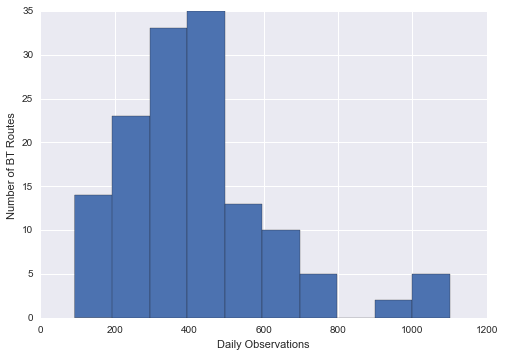

In [28]:
sums = class_of_device_obs_count_abs.groupby(['street_name', 'from_to_streets'])['Num observations'].sum()
ax = sums.hist()
ax.set_xlabel('Daily Observations')
ax.set_ylabel('Number of BT Routes')

**Note**: Fewer than 300 observations/day is approximately fewer than one observations per 5-minute bin

### Speed and Proportion of observations
This next section examines whether median speed by device type is different for different routes. Are some routes picker up more slower smartphones?

In [40]:
sql = '''WITH cnts AS (SELECT street_name, from_intersection || '-' ||to_intersection as from_to_streets,
    CASE WHEN device_type = 'WiFi' then 'cod = 0' ELSE device_type END AS "Device Type",
    COUNT(1) as "Num observations",
    percentile_cont(0.5) WITHIN GROUP (ORDER BY 3.6 * length/measured_time) as "Median Speed"
FROM bluetooth.observations_201711
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN king_pilot.bt_segments USING (analysis_id)
INNER JOIN bluetooth.segments USING (analysis_id)
WHERE device_class = 1 AND measured_time > 0
GROUP BY street_name, from_intersection, to_intersection, device_type)
, tots AS (SELECT street_name, from_to_streets, SUM("Num observations") AS total_cnt
FROM cnts
GROUP BY street_name, from_to_streets)
, most_popular_devices AS( SELECT "Device Type", SUM("Num observations") AS total_cnt
FROM cnts
GROUP BY "Device Type" 
ORDER BY total_cnt DESC LIMIT 8)
SELECT tots.street_name, tots.from_to_streets, dev."Device Type",
"Median Speed", 
COALESCE(100.0*"Num observations"/total_cnt, 0) as "% of Observations", COALESCE("Num observations", 0)as "Num observations"
FROM tots
INNER JOIN cnts USING (street_name, from_to_streets)
RIGHT OUTER JOIN (SELECT "Device Type", street_name, from_to_streets, row_number() OVER (ORDER BY total_cnt DESC) AS device_rank 
                  FROM  most_popular_devices
                  CROSS JOIN (SELECT DISTINCT street_name, from_to_streets FROM cnts) st
                  ) dev ON dev."Device Type" = cnts."Device Type" AND dev.street_name = cnts.street_name
                      AND dev.from_to_streets = cnts.from_to_streets
WINDOW w AS (PARTITION BY tots.street_name, tots.from_to_streets ORDER BY device_rank ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING)
ORDER BY street_name, from_to_streets'''

cod_med_speed = pandasql.read_sql(sql, con)

In [47]:
smartphone_hfd = cod_med_speed[cod_med_speed['Device Type'].isin(['Hands-free Device', 'Smart phone'])]
smartphone_hfd_piv = smartphone_hfd.pivot_table(values=['Median Speed', '% of Observations'], columns='Device Type', index=['street_name', 'from_to_streets'])
smartphone_hfd_piv

Median Speed              \
Device Type                            Hands-free Device Smart phone   
street_name      from_to_streets                                       
Adelaide         Jarvis-Parliament             37.216901   36.700000   
                 Spadina-University            12.018251   12.018251   
                 University-Yonge              15.573913   14.925000   
                 Yonge-Jarvis                  16.311504   15.108197   
Adelaide/Eastern Parliament-Broadview          23.879851   15.193043   
Bathurst         College-Dundas                21.837363   18.925714   
                 Dundas-College                20.863636   19.326316   
                 Dundas-Queen                  20.988000   19.614953   
                 FortYork-Front                18.675000   17.928000   
                 Front-FortYork                15.157895   13.500000   
                 Front-King                    15.960000   14.509091   
                 King-Front                    21.763636   20.817391   
                 King-Queen                    11.940000   11.106977   
                 Queen-Dundas                  17.203279   16.144615   
                 Queen-King                    11.106977   10.458394   
Broadview        Eastern-Queen                 17.012903   16.227692   
                 Queen-Eastern                 20.823529   22.595745   
College          Bathurst-University           14.319916   13.132653   
                 Parliament-University         13.809717   11.661573   
                 University-Bathurst           14.104110   12.242586   
                 University-Parliament         13.781818   12.645053   
Dufferin         Dundas-Queen                  27.883636   24.537600   
                 King-Queen                    15.682759   13.119231   
                 Queen-Dundas                  26.905263   24.151181   
                 Queen-King                    19.491429   17.055000   
Dundas           Bathurst-Dufferin             17.338289   16.372926   
                 Bathurst-Spadina              18.692308   16.092715   
                 Dufferin-Bathurst             17.603747   16.853812   
                 Dufferin-Roncesvalles         21.487889   20.228013   
                 Jarvis-Parliament             21.093750   18.750000   
...                                                  ...         ...   
Roncesvalles     Dundas-Queen                  15.273000   14.511164   
                 Queen-Dundas                  13.606236   12.888608   
Spadina          Bremner-Front                 26.190000   17.460000   
                 Dundas-Queen                  15.905455    9.774302   
                 Front-Bremner                 10.112360    8.571429   
                 Front-King                    14.554839   10.412308   
                 King-Front                    12.327273   10.705263   
                 King-Queen                    11.025000    7.453521   
                 Queen-Dundas                  16.170000    8.662500   
                 Queen-King                     8.714634    6.678505   
Strachan         King-Queen                    14.593548   13.848980   
                 Queen-King                    14.438298   12.010619   
University       College-Dundas                14.811429   12.126316   
                 Dundas-College                23.512500   17.773228   
                 Dundas-Queen                  23.770588   21.268421   
                 Front-King                    13.464000    5.364143   
                 King-Front                    16.584270    6.589286   
                 King-Queen                    12.757895    8.505263   
                 Queen-Dundas                  24.500000   12.875912   
                 Queen-King                    18.225000   13.254545   
Wellington       University-BlueJays           20.552727   15.754895   
                 Yonge-University              15.169655   13.921519   
Yonge       

In [69]:
smartphone_hfd_piv["% HFD"] = (5*round(smartphone_hfd_piv['% of Observations']['Hands-free Device']/5)).astype('int')
print(len(smartphone_hfd_piv['% HFD'].unique()))

6


In [96]:
NUM_COLORS = 6
cm = plt.get_cmap('YlOrRd')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

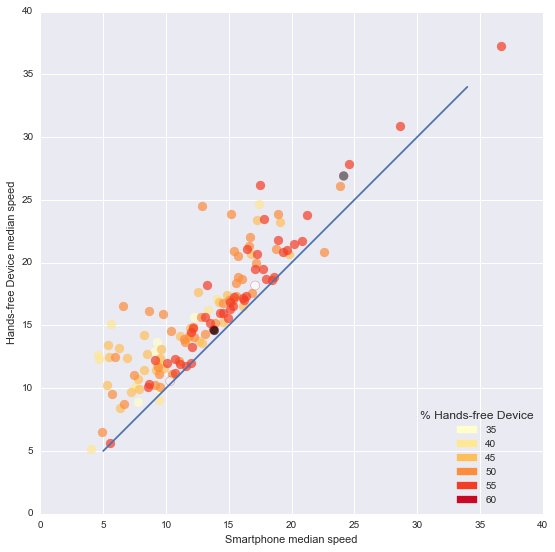

In [106]:
handles = []
fig, ax = plt.subplots(1,1, figsize=(9,9))
for i, perc in enumerate(sorted(smartphone_hfd_piv['% HFD'].unique())):
    data = smartphone_hfd_piv[np.isclose(smartphone_hfd_piv['% HFD'], perc)]
    ax.scatter(data['Median Speed']['Smart phone'], data['Median Speed']['Hands-free Device'],
               color= colors[i], s=80, alpha=0.7)
    handles.append(mpl.patches.Patch(color=colors[i], label=perc))
ax.plot(range(5,35), range(5,35), '-')
ax.set_xlabel('Smartphone median speed')
ax.set_ylabel('Hands-free Device median speed')
ax.legend(title="% Hands-free Device", handles=list(handles), loc='lower right',
          fancybox=True);

## Comparing 5-min aggregates
Now comparing the effect filtering keeping only Hands-free Device and `cod = 0` devices has on coverage and median speeds. 

In [113]:
con.rollback()

In [114]:
sql = '''CREATE MATERIALIZED VIEW bluetooth.aggr_5min_cars_only AS 
SELECT analysis_id, TIMESTAMP WITHOUT TIME ZONE 'epoch' +
INTERVAL '1 second' * (floor((extract('epoch' from rs.measured_timestamp)-1) / 300) * 300) as datetime_bin,
percentile_cont(0.5) WITHIN GROUP (ORDER BY rs.measured_time) AS travel_time,
COUNT(rs.user_id) AS obs
FROM bluetooth.observations_201711 rs
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN king_pilot.bt_segments USING (analysis_id)
WHERE rs.outlier_level = 0 AND device_class = 1 AND device_type IN ('Hands-free Device', 'WiFi')
GROUP BY analysis_id, (floor((extract('epoch' from rs.measured_timestamp)-1) / 300) * 300)

'''
cur = con.cursor()
cur.execute(sql)
con.commit()

AttributeError: 'psycopg2.extensions.cursor' object has no attribute 'commit'

In [36]:
aggr_5min_cars_only = pandasql.read_sql('SELECT * FROM bluetooth.aggr_5min_cars_only', con)
aggr_5min_nov = pandasql.read_sql("SELECT * FROM bluetooth.aggr_5min WHERE datetime_bin >= '2017-11-01' AND datetime_bin < '2017-12-01'", con)
#aggr_5min_cars_only.rename(columns={'travel_time':'tt'}, inplace=True)
datasets = [aggr_5min_nov, aggr_5min_cars_only]

In [66]:
# aggr_5min_cars_only.to_csv('aggr_5min_cars_only.csv')
aggr_5min_cars_only = pd.read_csv('aggr_5min_cars_only.csv')
aggr_5min_nov = pd.read_csv('nov_5min_aggr.csv')
aggr_5min_cars_only.rename(columns={'travel_time':'tt'}, inplace=True)
datasets = [aggr_5min_nov, aggr_5min_cars_only]

In [37]:
for dataset in datasets:
    dataset.datetime_bin = pd.to_datetime(dataset.datetime_bin)
    dataset['Weekday'] = dataset.datetime_bin.apply(lambda x: x.weekday())

In [28]:
data = datasets[1]
data = data[data['Weekday']==True].groupby([data.datetime_bin.dt.hour]).obs.count()/len(data['analysis_id'].unique())/len(data[data['Weekday']==True].datetime_bin.dt.date.unique())

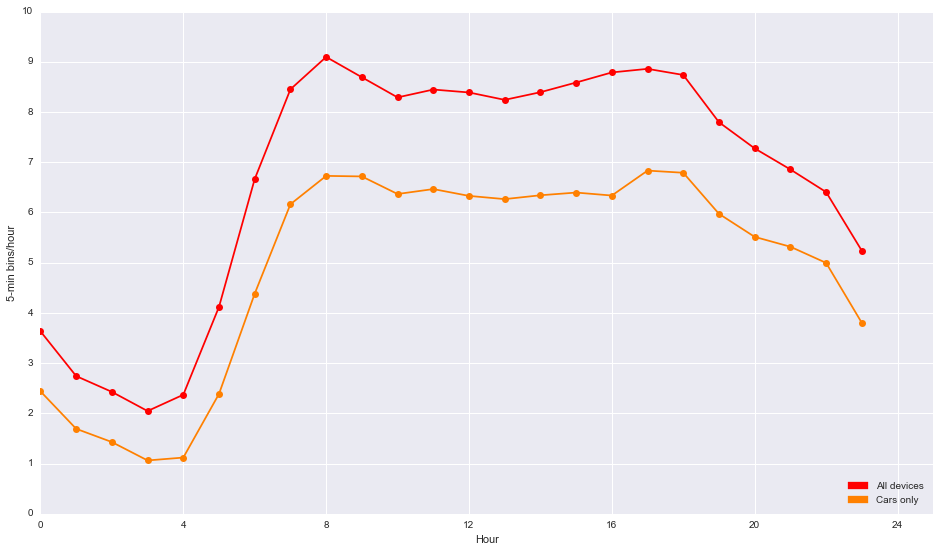

In [38]:
NUM_COLORS = 2
cm = plt.get_cmap('autumn')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
fig, ax = plt.subplots(1,1, figsize=(16, 9))
labels = ['All devices', 'Cars only']
handles = []

for i in [0,1]:
    data = datasets[i]
    data = data[data['Weekday']==True].groupby([data.datetime_bin.dt.hour]).obs.count()/len(data['analysis_id'].unique())/len(data[data['Weekday']==True].datetime_bin.dt.date.unique())
    ax.plot(data.index, data.values, color=colors[i], marker='o')
    handles.append(mpl.patches.Patch(color=colors[i], label=labels[i]))
ax.set_xlabel('Hour')
ax.set_xticks(range(0,28,4))
ax.set_yticks(range(0,11))
ax.set_ylabel('5-min bins/hour')
ax.legend(handles=list(handles), loc='lower right',
          fancybox=True);

So there's a drop of about 2 5-min bin observations per hour from weekday peak to peak, but how does this affect observed speeds?

In [ ]:
num_weekdays = 22


sql = '''WITH cnts AS(SELECT analysis_id, EXTRACT('hour' FROM datetime_bin) AS "Hour", 
1.0*COUNT(1)/{num_weekdays} AS obs_hour

    FROM bluetooth.aggr_5min_cars_only
    WHERE EXTRACT('isodow' FROM datetime_bin) < 6
    GROUP BY analysis_id, "Hour")
    
    SELECT "Hour", 
    percentile_cont(0.0) WITHIN GROUP(ORDER BY obs_hour) AS p_0,
percentile_cont(0.20) WITHIN GROUP(ORDER BY obs_hour) AS p_20,
percentile_cont(0.40) WITHIN GROUP(ORDER BY obs_hour) AS p_40,
percentile_cont(0.5) WITHIN GROUP(ORDER BY obs_hour) AS median,
percentile_cont(0.60) WITHIN GROUP(ORDER BY obs_hour) AS p_60,
percentile_cont(0.80) WITHIN GROUP(ORDER BY obs_hour) AS p_80,
percentile_cont(1.0) WITHIN GROUP(ORDER BY obs_hour) AS p_100
    FROM cnts
    GROUP BY "Hour"
'''.format(num_weekdays=num_weekdays)

aggr_5min_cars_only = pandasql.read_sql(sql, con)

In [26]:
sql = '''WITH cnts AS(SELECT analysis_id, EXTRACT('hour' FROM datetime_bin) AS "Hour", 
1.0*COUNT(1)/{num_weekdays} AS obs_hour

    FROM bluetooth.aggr_5min
    WHERE datetime_bin >= '2017-11-01' AND datetime_bin < '2017-12-01' AND EXTRACT('isodow' FROM datetime_bin) < 6
    GROUP BY analysis_id, "Hour")
    
    SELECT "Hour", 
    percentile_cont(0.0) WITHIN GROUP(ORDER BY obs_hour) AS p_0,
percentile_cont(0.20) WITHIN GROUP(ORDER BY obs_hour) AS p_20,
percentile_cont(0.40) WITHIN GROUP(ORDER BY obs_hour) AS p_40,
percentile_cont(0.5) WITHIN GROUP(ORDER BY obs_hour) AS median,
percentile_cont(0.60) WITHIN GROUP(ORDER BY obs_hour) AS p_60,
percentile_cont(0.80) WITHIN GROUP(ORDER BY obs_hour) AS p_80,
percentile_cont(1.0) WITHIN GROUP(ORDER BY obs_hour) AS p_100
    FROM cnts
    INNER JOIN king_pilot.bt_segments USING (analysis_id)
    GROUP BY "Hour"
'''.format(num_weekdays=num_weekdays)

aggr_5min_nov = pandasql.read_sql(sql, con)


datasets = [aggr_5min_nov, aggr_5min_cars_only]

In [27]:
NUM_COLORS = 5
cm = plt.get_cmap('autumn')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
titles = ['All devices', 'Cars only']

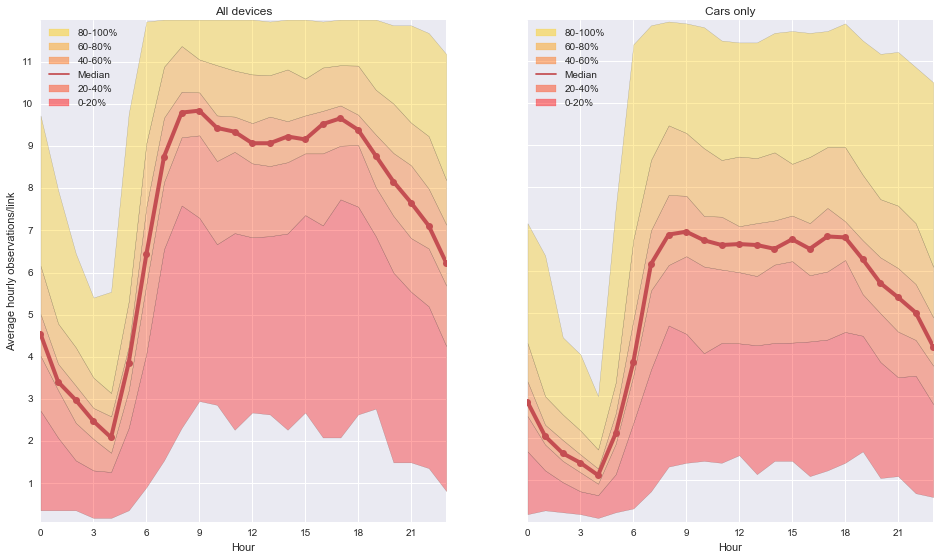

In [35]:
fig, ax = plt.subplots(1,2, figsize=(16,9), sharey=True)
handles = []
for percentile in range(0,5):
    label_elements = {'bottom': str(percentile * 20),
                      'top': str((percentile + 1) * 20)}
    label = "{bottom}-{top}%".format(**label_elements)
    if percentile == 2:
        handles.append(plt.Line2D((0,1),(0,0), color='r', label="Median"))
    handles.append(mpl.patches.Patch(color=colors[percentile],alpha=0.45,label=label))

for idx, data in enumerate(datasets):
    data.plot(x='Hour',y='median', ax=ax[idx],
                       color='r', linewidth=4, marker='o', label="Median")
    ax[idx].fill_between(data['Hour'].values, 
                    y1=data['p_0'],
                    y2=data['p_20'],
                    alpha=0.35, facecolor=colors[0],
                        label="0-20%")
    ax[idx].fill_between(data['Hour'].values, 
                    y1=data['p_20'],
                    y2=data['p_40'],
                    alpha=0.35, facecolor=colors[1],
                        label="20-40%")
    ax[idx].fill_between(data['Hour'].values, 
                    y1=data['p_40'],
                    y2=data['p_60'],
                    alpha=0.35, facecolor=colors[2],
                         label="40-60%")
    ax[idx].fill_between(data['Hour'].values, 
                    y1=data['p_60'],
                    y2=data['p_80'],
                    alpha=0.35, facecolor=colors[3],
                        label="60-80%")
    ax[idx].fill_between(data['Hour'].values, 
                    y1=data['p_80'],
                    y2=data['p_100'],
                    alpha=0.35, facecolor=colors[4],
                        label="80-100%")
    ax[idx].set_title(titles[idx])
    ax[idx].set_ylabel('Average hourly observations/link')
    ax[idx].set_yticks(range(0,12))
    ax[idx].set_xlabel('Hour')
    ax[idx].set_xticks(range(0,24,3))
    ax[idx].legend(handles=handles[::-1], loc='upper left');

For 50% of routes, the average daily number of 5-min bin observations drops by between 2-3 observations/hour in the midday. nevertheless, approximately 60% of routes have better than 50% coverage (6 5-min datapoints per hour) from 8AM to 6PM on weekdays. 

In [42]:
sql = ''' SELECT 'All Devices' as "Device Types", analysis_id, EXTRACT('hour' FROM datetime_bin) AS "Hour",
3.6*length / tt AS "Speed (km/hr)"

FROM bluetooth.aggr_5min
INNER JOIN king_pilot.bt_segments USING (analysis_id)
INNER JOIN bluetooth.segments USING (analysis_id)
WHERE datetime_bin >= '2017-11-01' AND datetime_bin < '2017-12-01' AND EXTRACT('isodow' FROM datetime_bin) < 6
AND tt > 0 AND EXTRACT('hour' FROM datetime_bin) BETWEEN 8 AND 20
AND 3.6*length/tt <= 70

UNION ALL
SELECT 'Cars only' as device_type, analysis_id, EXTRACT('hour' FROM datetime_bin) AS "Hour", 3.6*length / tt AS speed

FROM bluetooth.aggr_5min_cars_only
INNER JOIN king_pilot.bt_segments USING (analysis_id)
INNER JOIN bluetooth.segments USING (analysis_id)
WHERE EXTRACT('isodow' FROM datetime_bin) < 6 AND tt > 0 AND EXTRACT('hour' FROM datetime_bin) BETWEEN 8 AND 20
 AND 3.6*length/tt <= 70
'''

speeds = pandasql.read_sql(sql, con)

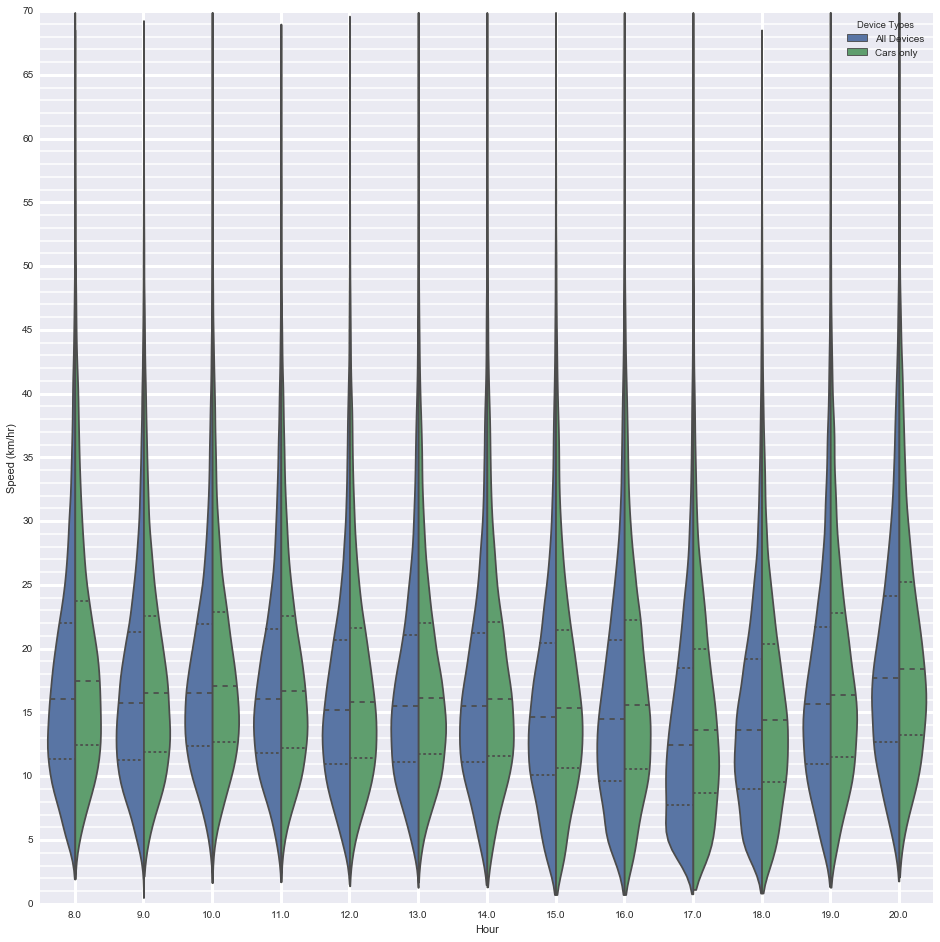

In [52]:
fig, ax = plt.subplots(figsize=(16,16))
sns.violinplot(x="Hour", y="Speed (km/hr)", hue="Device Types", inner="quart",
                    data = speeds, cut=0, ax=ax, alpha=0.9,
                    split=True)
ax.set_yticks(range(0,75,5))
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=3)
ax.grid(b=True, which='minor', color='w', linewidth=1.5);

## Observations
In the peak hours (8,9, and 16, 17), the difference in median speeds is approximately 1 km/hr between the two distributions across all downtown segments. For hours where the median speed is lowest (16,17,18), there is a noticeable second mode at the lower end of the distribution of speed observations for all devices, implying that pedestrian smartphones appear to be detected more when overall speeds are lower. 

The speed difference in the two distributions is not the 2km/hr we saw in the violin plots [in this notebook](https://github.com/CityofToronto/bdit_king_pilot_dashboard/blob/data_pipeline/bluetooth/Baseline_device_filtering.ipynb) because this difference is attenuated by:
 * the **All Devices** distribution includes nearly 50% car observations
 * the aggregation to 5-minutes

### Changes to Pilot Reported Travel Times
Creating new views called `king_pilot.tt_30min_cars_only` and `king_pilot.dash_daily_nov_cars_only` aggregating the data in `bluetooth.aggr_5min_cars_only` using the same procedure as the pilot reporting, the below looks at the impacts on the reported travel times.

In [3]:
sql = '''WITH prev_aggr AS( SELECT street, direction, day_type, period, avg(tt) as prev_mean
FROM king_pilot.dash_daily_dev
where category = 'Pilot'
GROUP BY street, direction, day_type, period)
, cars_only_aggr AS(SELECT street, direction, day_type, period, avg(tt) as new_mean
FROM king_pilot.dash_daily_nov_cars_only
where category = 'Pilot'
GROUP BY street, direction, day_type, period
)
SELECT street, direction, day_type, period, prev_mean - new_mean as "Travel Time Difference"

from cars_only_aggr
NATURAL JOIN prev_aggr
'''
tt_diffs = pandasql.read_sql(sql, con)

In [4]:
tt_diffs[['day_type', 'period']].drop_duplicates()

,day_type,period
0,Weekday,AM Peak
1,Weekday,Evening
2,Weekday,Midday
3,Weekday,PM Peak
4,Weekend,Afternoon
5,Weekend,Evening
6,Weekend,Morning


''

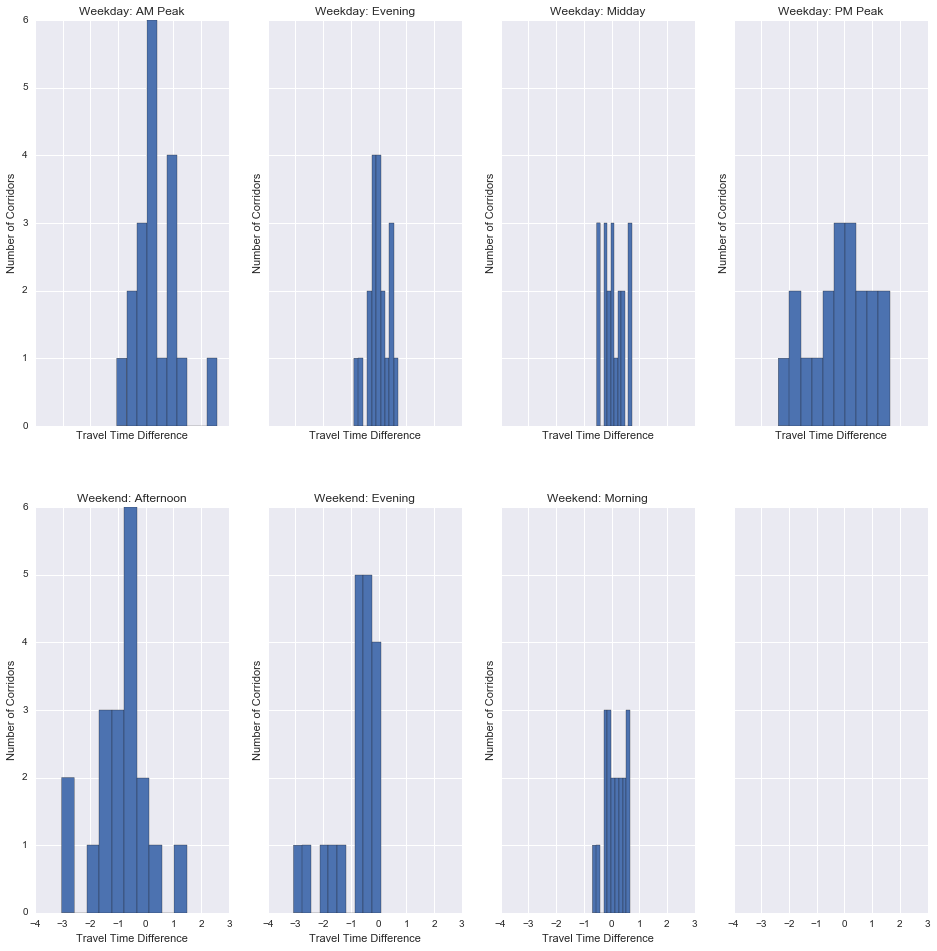

In [18]:


#From https://stackoverflow.com/a/27430940/4047679
# fig, big_axes = plt.subplots( figsize=(15.0, 15.0) , nrows=3, ncols=1, sharey=True) 
# for row, day_type in enumerate(tt_diffs['day_type'].unique()):
    

fig, axes = plt.subplots(2,4, figsize=(16,16), sharex=True, sharey=True)
for row, day_type in enumerate(tt_diffs['day_type'].unique()):
    for col, period in enumerate(tt_diffs[tt_diffs['day_type']==day_type].period.unique()):
        tt_diffs[(tt_diffs['day_type']==day_type) & (tt_diffs['period']==period)]['Travel Time Difference'].hist(ax=axes[row][col])
        ax = axes[row][col]
        ax.set_xlabel('Travel Time Difference')
        ax.set_ylabel('Number of Corridors')
        ax.set_title(day_type +': ' + period)
#         print(str(row)+', ' +  str(col)+ day_type +': ' + period)
;